In [ ]:
!pip uninstall -y numpy pandas scipy matplotlib
!pip install numpy==1.24.4
!pip install pandas scipy matplotlib
!pip install u8darts[all]

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 60.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires pandas>=0.24.0, which is not installed.
pymc 5.21.1 requires scipy>=1.4.1, which is not installed.
plotnine 0.14.5 requires matplotlib>=3.8.0, which is not installed.
plotnine 0.14.5 requires pandas>=2.2.0, which is not installed.
plotnine 0.14.5 requires scipy>=1.8.0, which i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 269.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 83.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
     ━

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from darts.metrics import mae, mape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
import numpy as np

# Электропотребление


In [ ]:
# Загрузка
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False, na_values="?")
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df[["datetime", "Global_active_power"]].dropna()
df = df.set_index("datetime").resample("H").mean().interpolate()

# Оставим последние 60 дней
df = df.tail(60 * 24).reset_index()

<ipython-input-7-dbb31e30bdc7>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("datetime").resample("H").mean().interpolate()


In [ ]:
# Преобразование в TimeSeries
ts = TimeSeries.from_dataframe(df, time_col="datetime", value_cols="Global_active_power", freq="H")

# Масштабируем
scaler = Scaler()
ts_scaled = scaler.fit_transform(ts)

# Разделим на train/test
train, test = ts_scaled[:-24], ts_scaled[-24:]


/usr/local/lib/python3.11/dist-packages/darts/timeseries.py:5301: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [ ]:
# Построение и обучение модели


model = NBEATSModel(
    input_chunk_length=168,   # 7 дней
    output_chunk_length=24,   # 1 день
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model.fit(train, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.3 M  | train
-------------------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, n_epochs=100, batch_size=32, random_state=42)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

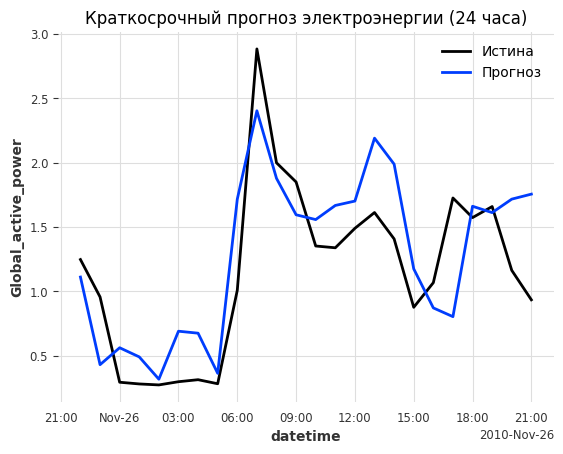

In [ ]:
# Прогноз

forecast = model.predict(n=24)
forecast = scaler.inverse_transform(forecast)
test = scaler.inverse_transform(test)

# Визуализация

test.plot(label="Истина", lw=2)
forecast.plot(label="Прогноз", lw=2)
plt.title("Краткосрочный прогноз электроэнергии (24 часа)")
plt.xlabel("datetime")
plt.ylabel("Global_active_power")
plt.legend()
plt.show()


In [ ]:
# Оценка
y_true = test.values().flatten()
y_pred = forecast.values().flatten()

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.4f}")

RMSE: 0.4257
MAE: 0.3506


# Финансовые данные

In [ ]:
# Загрузка данных
df = pd.read_json("sber (1).json")
df.sort_values("date", inplace=True)
df = df.drop_duplicates(subset='date', keep='first')
full_date_range = pd.date_range(df["date"].min(), df["date"].max(), freq="B")
df = df.set_index("date").reindex(full_date_range)
df = df.reset_index().rename(columns={"index": "date"})
df = df.interpolate()

In [ ]:
# Создаём два временных ряда (TimeSeries) в Darts:
#    - Целевой (таргет) = close
#    - Признаковый (exogenous) = open
ts_close = TimeSeries.from_dataframe(df, time_col="date", value_cols="close", freq="B")
ts_open  = TimeSeries.from_dataframe(df, time_col="date", value_cols="open",  freq="B")

In [ ]:
from darts.dataprocessing.transformers import Scaler

# Создаём два скейлера — для таргета и для признаков
scaler_close = Scaler()
scaler_open = Scaler()

# Масштабируем оба ряда
ts_close_scaled = scaler_close.fit_transform(ts_close)
ts_open_scaled = scaler_open.fit_transform(ts_open)

In [ ]:
ts_close_scaled

<TimeSeries (DataArray) (date: 784, component: 1, sample: 1)> Size: 6kB
array([[[0.10358355]],

       [[0.120201  ]],

       [[0.14589853]],

       [[0.18596553]],

       [[0.23361396]],

       [[0.28430379]],

       [[0.23185084]],

       [[0.17675321]],

       [[0.20275929]],

       [[0.18609777]],

...

       [[0.96535461]],

       [[0.98964164]],

       [[0.98100234]],

       [[0.98646802]],

       [[0.98095826]],

       [[0.97747609]],

       [[0.96077049]],

       [[0.96222506]],

       [[0.94208137]],

       [[0.92766783]]])
Coordinates:
  * date       (date) datetime64[ns] 6kB 2022-03-28 2022-03-29 ... 2025-03-27
  * component  (component) <U5 20B 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
ts_open_scaled

<TimeSeries (DataArray) (date: 784, component: 1, sample: 1)> Size: 6kB
array([[[0.14674827]],

       [[0.12761281]],

       [[0.17385683]],

       [[0.16678878]],

       [[0.20880921]],

       [[0.26811188]],

       [[0.31582123]],

       [[0.20238762]],

       [[0.20062061]],

       [[0.22626385]],

...

       [[0.94578287]],

       [[0.96599578]],

       [[0.98974271]],

       [[0.98241607]],

       [[0.98633797]],

       [[0.97939922]],

       [[0.97707193]],

       [[0.96302202]],

       [[0.96259104]],

       [[0.94367108]]])
Coordinates:
  * date       (date) datetime64[ns] 6kB 2022-03-28 2022-03-29 ... 2025-03-27
  * component  (component) <U4 16B 'open'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# 3. Делим выборку на train/test (24 последних дня в test).
TRAIN_SIZE = len(ts_close) - 24
train_close = ts_close_scaled[:TRAIN_SIZE]
test_close  = ts_close_scaled[TRAIN_SIZE:]
train_open  = ts_open_scaled[:TRAIN_SIZE]
test_open   = ts_open_scaled[TRAIN_SIZE:]

In [ ]:
# 4. Создаём модель N-BEATS
model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=24,
    n_epochs=100,
    random_state=42,
    layer_widths=512,
    generic_architecture=True,
    dropout=0.1,
    batch_size=32
)

In [ ]:
# 5. Обучаем модель на тренировочной части: целевой ряд + exogenous-ряд
model.fit(
    series=train_close,
    past_covariates=train_open,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 24.7 M | train
-------------------------------------------------------------
24.7 M    Trainable params
2.9 K     Non-trainable params
24.7 M    Total params
98.997    Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1, activation=ReLU, input_chunk_length=30, output_chunk_length=24, n_epochs=100, random_state=42, batch_size=32)

In [ ]:
# 6. Делаем прогноз на 24 шага вперёд
pred_close = model.predict(
    n=24,
    past_covariates=train_open
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

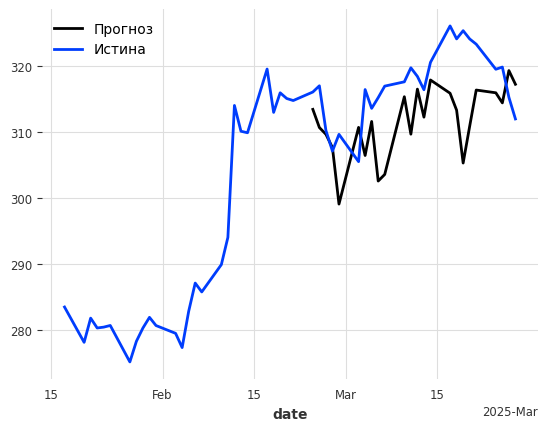

In [ ]:
pred = scaler_close.inverse_transform(pred_close)

pred.plot(label="Прогноз")
ts_close[-50:].plot(label="Истина")

In [ ]:
# 7. Оценим ошибку на тестовой части
mae_error  = mae(test_close,  pred_close)
mape_error = mape(test_close, pred_close)
rmse_error = rmse(test_close, pred_close)
print(f"MAE = {mae_error:.3f}, MAPE = {mape_error:.2f}%", f"RMSE = {rmse_error:.3f}")

MAE = 0.030, MAPE = 3.15% RMSE = 0.037
